In [18]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt
import xmlrpc.client
import pandas as pd
import os

class Params:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    
    @property
    def F_o(self):
        return self.Omega_o / (2 * np.pi)

    @property
    def Omega_o(self):
        return 1 / np.sqrt(self.L_r * self.C_r)
    
    @property
    def Omega_s(self):
        return 2 * np.pi * self.F_s

    @property
    def n(self):
        return self.n_pri / self.n_sec
        
    @property
    def L_n(self):
        return self.L_m / self.L_r

    @property
    def Omega_n(self):
        return self.Omega_s / self.Omega_o

    @property
    def K_d(self):
        """ (7) """
        return 2 / np.pi * self.L_n / (np.sin(self.Omega_n * np.pi / 2))
        """ 2 """
        return -4 * self.V_g / np.pi * 1/(self.Omega_o * self.L_n)

def get_tfs(p: Params):

    L_r = p.L_r
    L_m = p.L_m
    C_r = p.C_r
    C_f = p.C_f
    n = p.n
    R_L = p.R_L
    V_g = 2 * p.V_g # account for full-bridge inverter in PLECS model
    L_n = p.L_n
    F_s = p.F_s
    F_o = p.F_o
    Omega_s = p.Omega_s
    Omega_o = p.Omega_o

    Omega_n = p.Omega_n

    X_eq = Omega_s * L_r - 1 / (Omega_s * C_r) # equivalent reactance (Ohms)
    R_eq = 8 / np.pi**2 * n**2 * R_L # equivalent resistance (Ohms)
    Q = np.sqrt(L_r / C_r) / (n**2 * R_L)

    s = ctrl.TransferFunction([1, 0], [1])

    """ For F_s >= F_o: (14) """
    if F_s >= F_o:
        G_DC = (
            # leading terms
            (V_g / (2 * n)) * (L_n / (Omega_o * Omega_n)) *
            ( # numerator 
                (1/Omega_n**2 - Omega_n**2) * \
                (np.pi**2/8 * Q * L_n)**2 - \
                (L_n + 1 - 1/Omega_n**2) * \
                (2 / Omega_n**2)
            ) / 
            ( # denominator
                np.sqrt(
                    (L_n + 1 - 1 / Omega_n**2)**2 + \
                    ((1/Omega_n - Omega_n) * np.pi**2/8 * Q * L_n)**2
                )
            ) ** 3
        )

        L_e = (1 + Omega_o**2 / Omega_s**2) * L_r

        T_omega_s_to_v_o = G_DC * (X_eq**2 + R_eq**2) / (
            (s**2 * L_e**2 + s*L_e*R_eq + X_eq**2) * (1 + R_L*C_f*s) + \
            R_eq * (s*L_e + R_eq)
        )

    elif F_s < F_o:
        G_DC = (V_g / (2 * n) * L_n / Omega_o *
            ( # numerator 
                (
                    (1/Omega_n**2 - Omega_n**2) * \
                    (np.pi**2/8 * Q * L_n)**2 - \
                    (L_n + 1 - 1/Omega_n**2) * \
                    (2 / Omega_n**2)
                ) * \
                (1 / Omega_n) * \
                (1 / np.sin(np.pi / 2 * Omega_n)) + \
                (
                    (L_n + 1 - 1/Omega_n**2)**2 + \
                    ((1/Omega_n - Omega_n) * np.pi**2/8 * Q * L_n)**2
                ) * \
                (-np.pi/2 * np.cos(np.pi/2 * Omega_n) / np.sin(np.pi/2 * Omega_n))
            ) /
            ( # denominator
                np.sqrt(
                    (L_n + 1 - 1 / Omega_n**2)**2 + \
                    ((1/Omega_n - Omega_n) * np.pi**2/8 * Q * L_n)**2
                )
            ) ** 3
        )

        L_e = L_r * (1 + 1 / Omega_n**2) + L_m * (1 - Omega_n)
        omega_p = np.sqrt(1/(L_e * np.pi**2/(8*n**2) * C_f))
        Q_p = 8 * n / np.pi**2 * R_L * np.sqrt(C_f / L_e)
        # L_e = (1 + Omega_o**2 / Omega_s**2) * L_r + (1 - Omega_s / Omega_o) * L_m
        T_omega_s_to_v_o = G_DC * 1 / (1 + s/(Q_p * omega_p) + (s**2 / omega_p**2))

    else:
        raise ValueError("Invalid switching frequency")

    return T_omega_s_to_v_o




<TransferFunction>: sys[12]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


             -1.401e+12
------------------------------------
9.959e+06 s^2 + 7.23e+10 s + 7.2e+17



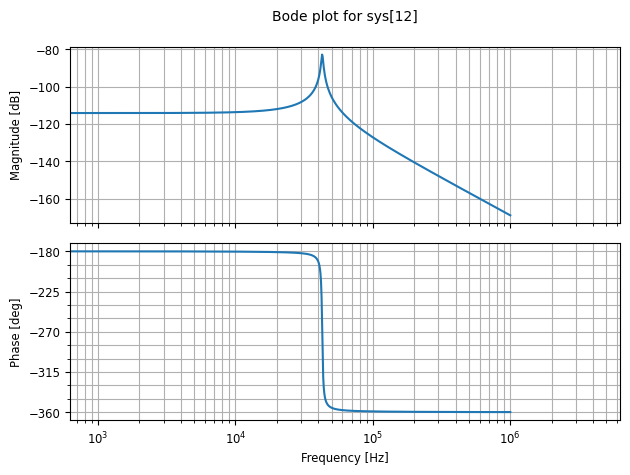

In [3]:
p = Params(**{
    "L_r": 2e-6,  # resonant inductance (H)
    "L_m": 10e-6,  # magnetizing inductance (H)
    "C_r": 5.6e-9,  # resonant capacitance (F)
    "C_f": 100e-6,   # filter capacitance (F)
    "n_pri": 6,     # number of primary turns
    "n_sec": 1,     # number of secondary turns
    "R_L": 1.53,       # load resistance (Ohms) 
    "V_g": 270,      # input voltage (V)
    "F_s": 1.5e6,   # switching frequency (Hz)
    "C_v_init": 48,
})

Gp = get_tfs(p)
# Gp.display_format 
print(Gp)
ctrl.bode(Gp, dB=True, Hz=True, 
        omega_limits=(100*2*np.pi, 1e6*2*np.pi))

In [4]:
ss = ctrl.tf2ss(Gp)
ss

StateSpace(array([[-7.25961264e+03, -7.22988726e+10],
       [ 1.00000000e+00,  0.00000000e+00]]), array([[1.],
       [0.]]), array([[      0.        , -140632.42067018]]), array([[0.]]))

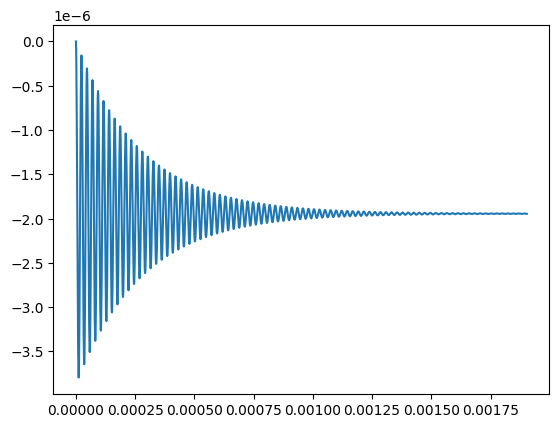

In [5]:
t, x =  ctrl.step_response(ss)
plt.figure()
plt.plot(t, x)

In [6]:
eigenvalues = np.linalg.eigvals(ss.A)
eigenvalues

array([-3629.80632202+268859.99540151j, -3629.80632202-268859.99540151j])

In [7]:
poles, zeros = ctrl.poles(Gp), ctrl.zeros(Gp)
print(poles)

[-3629.80632202+268859.99540151j -3629.80632202-268859.99540151j]


In [8]:
R = 1
rho = 100
Q = rho * ss.C.T * ss.C
K, S, E = ctrl.lqr(ss.A, ss.B, Q, R)
K

array([[1.88406499e-03, 1.36775838e+01]])

In [9]:
T = ctrl.feedback(ss, K)

ValueError: State space systems don't have compatible inputs/outputs for feedback.

Type 2 K-Factor

-1697368185.9600852


In [ ]:
# Inputs
f_c = 1e3
PM_desired = 60

omega_c = 2 * np.pi * f_c

resp = Gp.frequency_response(omega_c)
print(resp)

mag_sys = resp.magnitude[0]

# subtract pi to adjust for the negative gain of the plant transfer function
phi_sys_deg = (resp.phase[0] - np.pi) * 180 / np.pi
# print(f"mag_sys: {mag_sys}")
print(f"phi_sys_deg: {phi_sys_deg}")

phi_boost = PM_desired - phi_sys_deg - 90
print(f"phi_boost: {phi_boost}")


<FrequencyResponseData>: sys[29]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

Freq [rad/s]  Response
------------  ---------------------
    6283.185  -1.945e-06+1.227e-09j
phi_sys_deg: [[-0.03615196]]
phi_boost: [[-29.96384804]]


In [ ]:
np.tan(np.deg2rad(45))

0.9999999999999999

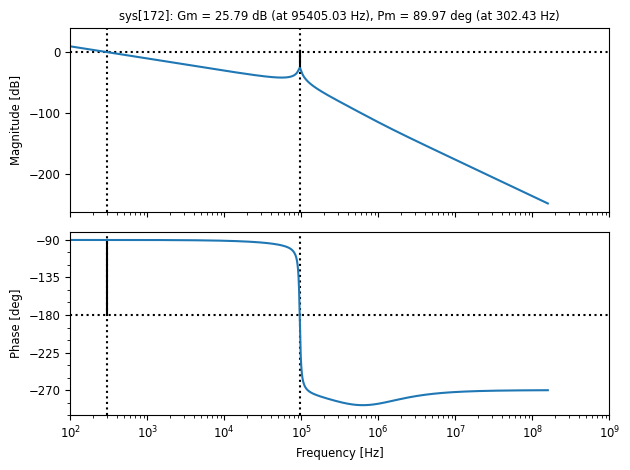

In [ ]:
s = ctrl.TransferFunction.s 
# Controller designed with sisotool
Gc = -5.04e8 * 1/s * (s + 5.34e6) / (s + 2.755e6)
ctrl.bode(Gp * Gc, dB=True, omega_limits=(10e1, 10e8), display_margins=True, Hz=True)

In [ ]:
gm, pm, wcg, wcp = ctrl.margin(Gp * Gc)
print(20 * np.log10(gm))

1.9e3 / (2 * np.pi)

25.75981162611064


302.3943918746011

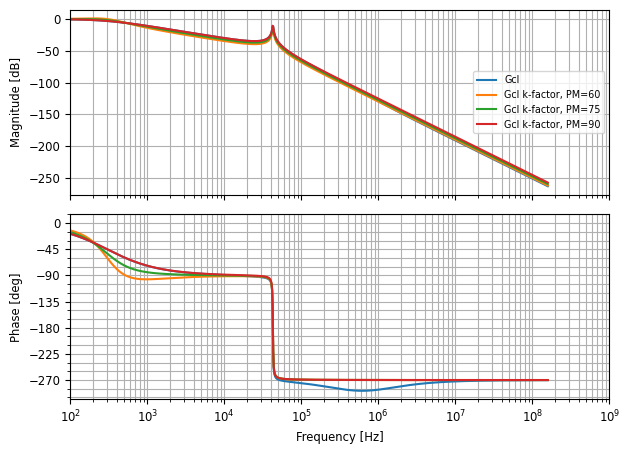

In [ ]:
Gcl = ctrl.feedback(Gp*Gc, 1)
plt.figure()
ctrl.bode(Gcl, dB=True, omega_limits=(10e1, 10e8), label="Gcl", Hz=True)

Gcls = []
s = ctrl.TransferFunction.s 
for pm in [60, 75, 90]:
    phi_boost = pm - 0 - 90
    k = np.tan(np.deg2rad(phi_boost/2 + 45))

    omega_c = 1.9e3
    omega_z = omega_c/k
    omega_p = k*omega_c

    Kc = omega_c / (k * -1.94e-6)
    Gc_kfactor = (Kc/s) * (1 + s/omega_z) / (1 + s/omega_p)

    Gcl1 = ctrl.feedback(Gp*Gc_kfactor, 1)
    ctrl.bode(Gcl1, dB=True, omega_limits=(10e1, 10e8), label=f"Gcl k-factor, PM={pm}", Hz=True)
    Gcls.append({
        "Gcl": Gcl1,
        "PM": pm,
    })


C:\Users\nickk\AppData\Local\Temp\ipykernel_34848\1472770917.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(t, x, 'r--', label="sisotool", color="magenta", linewidth=2.5)


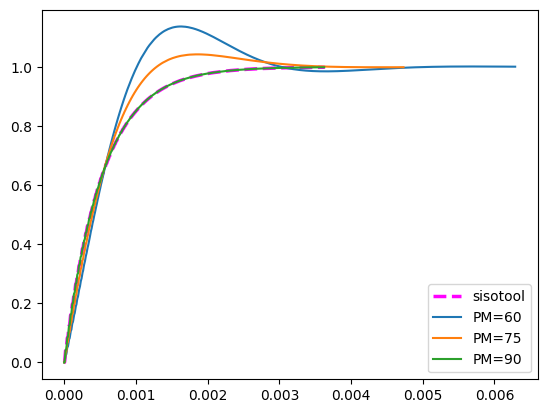

In [ ]:
t, x = ctrl.step_response(Gcl)
plt.plot(t, x, 'r--', label="sisotool", color="magenta", linewidth=2.5)
for item in Gcls:
    t, x2 = ctrl.step_response(item["Gcl"])
    plt.plot(t, x2, label=f"PM={item['PM']}")
plt.legend()

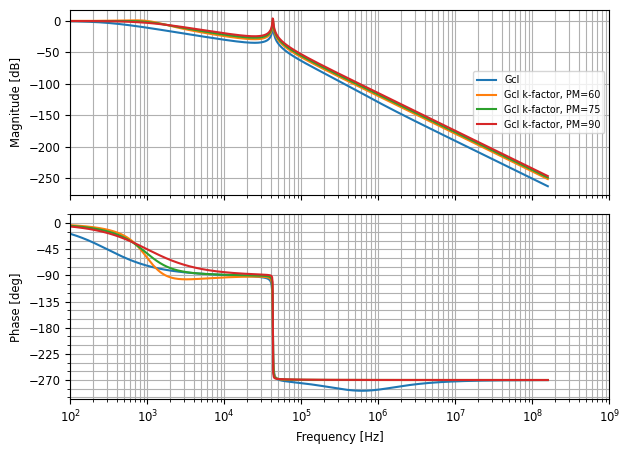

In [ ]:
Gcl = ctrl.feedback(Gp*Gc, 1)
plt.figure()
ctrl.bode(Gcl, dB=True, omega_limits=(10e1, 10e8), label="Gcl", Hz=True)

Gcls = []
s = ctrl.TransferFunction.s 
for pm in [60, 75, 90]:
    phi_boost = pm - 0 - 90
    k = np.tan(np.deg2rad(phi_boost/2 + 45))

    omega_c = 1000 * 2 * np.pi
    omega_z = omega_c/k
    omega_p = k*omega_c

    Kc = omega_c / (k * -1.94e-6)
    Gc_kfactor = (Kc/s) * (1 + s/omega_z) / (1 + s/omega_p)

    Gcl1 = ctrl.feedback(Gp*Gc_kfactor, 1)
    ctrl.bode(Gcl1, dB=True, omega_limits=(10e1, 10e8), label=f"Gcl k-factor, PM={pm}", Hz=True)
    Gcls.append({
        "Gcl": Gcl1,
        "PM": pm,
    })


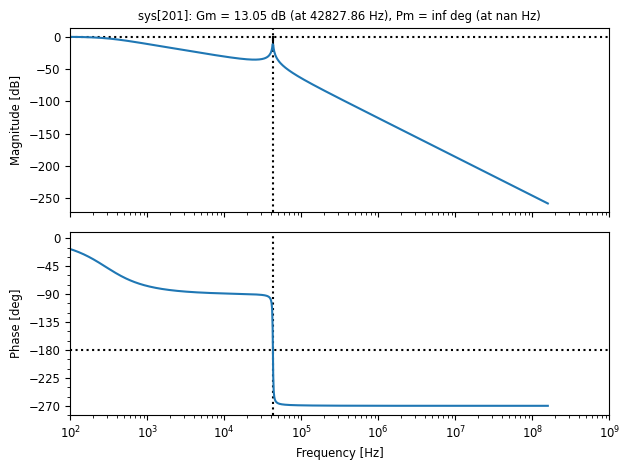

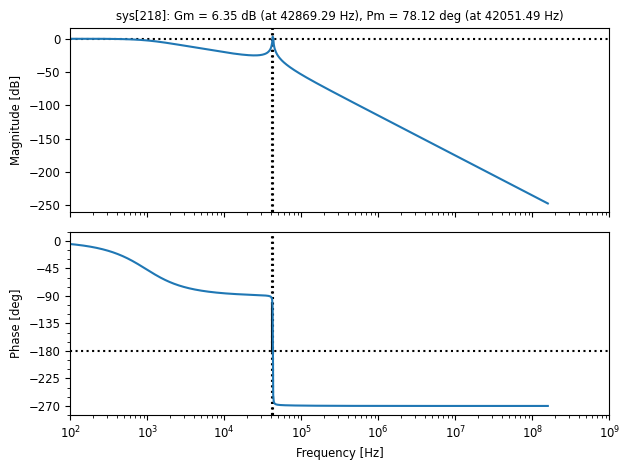

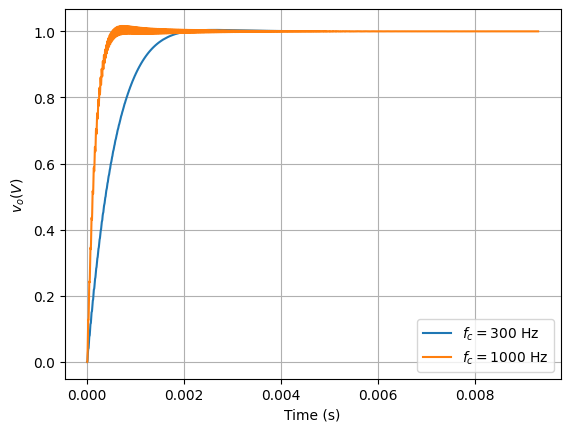

In [14]:
Gcls = []
s = ctrl.TransferFunction.s 
pm = 85
for f_c in [300, 1000]:
    omega_c = f_c * 2 * np.pi
    phi_boost = pm - 0 - 90
    k = np.tan(np.deg2rad(phi_boost/2 + 45))

    omega_z = omega_c/k
    omega_p = k*omega_c

    Kc = omega_c / (k * -1.94e-6)
    Gc_kfactor = (Kc/s) * (1 + s/omega_z) / (1 + s/omega_p)

    Gcl1 = ctrl.feedback(Gp*Gc_kfactor, 1)
    plt.figure()
    # try:
    #     gm, pm, _, _, = ctrl.margin(Gcl1)
    # except:
    #     gm = float('nan')
    # gm_db = 20 * np.log10(gm)
    gm_db = 0.0
    ctrl.bode(Gcl1, dB=True, omega_limits=(10e1, 10e8), label=f"Gcl k-factor, f_c={f_c} Hz, GM={gm_db:.2f}dB", Hz=True, display_margins=True)
    Gcls.append({
        "Gcl": Gcl1,
        "f_c": f_c,
    })

plt.figure()
for item in Gcls:
    t, x2 = ctrl.step_response(item["Gcl"])
    plt.plot(t, x2, label="$f_c = $" + f"{item['f_c']} Hz")
plt.xlabel("Time (s)")
plt.ylabel("$v_o (V)$")
plt.grid(which="both")
plt.legend()

Delay Modeling

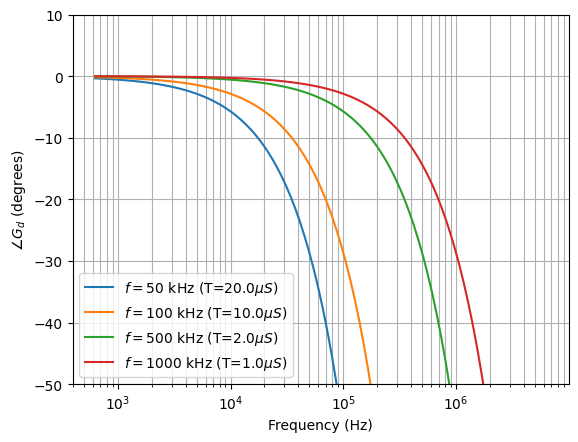

In [10]:

freqs = [50e3, 100e3, 500e3, 1e6]
for freq in freqs:
    Ts = 1/freq
    Td = Ts / 2
    omega = 2*np.pi*np.logspace(2, 6, 100)
    G_d_angle_deg = (-omega * Td) * 180 / np.pi
    plt.plot(omega, G_d_angle_deg, label="$f=$" + f"{freq/1e3:.0f} kHz (T={Ts * 1e6}" + "$\mu S$)")
plt.legend()
plt.semilogx()
plt.ylim((-50, 10))
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\angle G_d$ (degrees)")
plt.grid(which="both")


In [21]:
def run_plecs(p: Params):
    s = xmlrpc.client.Server('http://localhost:1080/RPC2')
    sim_name = "llc_closed_loop"
    sim_path = os.path.join(os.getcwd(), f'{sim_name}.plecs')
    s.plecs.load(sim_path)
    # get p.__dict__ as well as all properties
    ModelVars = {**p.__dict__, **{k: getattr(p, k) for k in dir(p) if not k.startswith("__")}}
    # coerce to float
    ModelVars = {k: float(v) for k, v in ModelVars.items()}

    result = s.plecs.analyze(sim_name, 'Multitone Analysis (Forward Path)', 
    {"ModelVars": ModelVars, "SolverOpts": {}})
    df = pd.DataFrame({
        "F": result["F"],
        "Gr": result["Gr"][0],
        "Gi": result["Gi"][0],
    })
    df["magnitude"] = 20 * np.log10(np.sqrt(df["Gr"]**2 + df["Gi"]**2))
    df["phase"] = np.arctan2(df["Gi"], df["Gr"]) * (180 / np.pi)
    return df



In [26]:

p = Params(**{
    "L_r": 2e-6,  # resonant inductance (H)
    "L_m": 10e-6,  # magnetizing inductance (H)
    "C_r": 5.6e-9,  # resonant capacitance (F)
    "C_f": 100e-6,   # filter capacitance (F)
    "n_pri": 6,     # number of primary turns
    "n_sec": 1,     # number of secondary turns
    "R_L": 1.53,       # load resistance (Ohms) 
    "V_g": 270,      # input voltage (V)
    "F_s": 1.33e6,   # switching frequency (Hz)
    "C_v_init": 48,
})

In [28]:
df = run_plecs(p)

C:\Users\nickk\AppData\Local\Temp\ipykernel_26576\409150061.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax[0].plot(df["F"] , df["magnitude"], 'r--', label=f"PLECS", color="magenta", linewidth=2.5)
C:\Users\nickk\AppData\Local\Temp\ipykernel_26576\409150061.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax[1].plot(df["F"] , df["phase"], 'r--', label=f"PLECS", color="magenta", linewidth=2.5)


Text(0.5, 0.98, '')

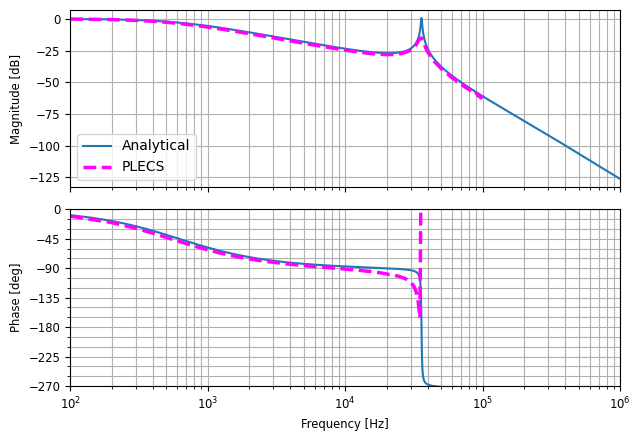

In [32]:

# df = pd.read_csv("llc_plecs.csv")

Gp = get_tfs(p)
s = ctrl.TransferFunction.s 
# Controller designed with sisotool
Gc = -5.04e8 * 1/s * (s + 5.34e6) / (s + 2.755e6)
Gcl = ctrl.feedback(Gp*Gc, 1)

# print the order of the transfer function
ctrl.bode(Gcl, dB=True, Hz=True, omega_limits=(100*2*np.pi, 1e6*2*np.pi), label=f"Analytical")
ax = plt.gcf().get_axes()
ax[0].plot(df["F"] , df["magnitude"], 'r--', label=f"PLECS", color="magenta", linewidth=2.5)
ax[1].plot(df["F"] , df["phase"], 'r--', label=f"PLECS", color="magenta", linewidth=2.5)

# set the x-limits
plt.xlim(1e2, 1e6)
# get both axes of the 2,1 subplots
ax = plt.gcf().get_axes()
# make the fontsize smaller than 'small'
ax[0].legend(loc='lower left')
ax[1].set_ylim(-270, 0)
fig = plt.gcf()
fig.suptitle("")